## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
from copy import deepcopy
from urllib.parse import urlparse
from scipy.stats import spearmanr

from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.optim import lr_scheduler

from tqdm import tqdm
from transformers import DistilBertTokenizer, BertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset3, TextDataset4
from bert import CustomBert2, CustomBert3, CustomBert4
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from sentence_embed import get_use_embedding_features, get_distill_bert_features
from create_features import get_dist_features, get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

Using TensorFlow backend.


In [2]:
bert_type = 'base'

## Loading and preparing data

In [3]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [4]:
max_seq_len = 512
max_t_len = 29
max_q_len = 240
max_a_len = 240
tokenizer = BertTokenizer.from_pretrained(f'bert-{bert_type}-uncased')

def encode(t, q, a, tokenizer=tokenizer):
    t_ids = [tokenizer.cls_token_id] + tokenizer.encode(t, add_special_tokens=False, max_length=max_seq_len)
    q_ids = tokenizer.encode(q, add_special_tokens=False, max_length=max_seq_len)
    a_ids = tokenizer.encode(a, add_special_tokens=False, max_length=max_seq_len)
    
    n_t, n_q, n_a = len(t_ids), len(q_ids), len(a_ids)
    cut_off = n_t + n_q + n_a - (max_seq_len - 3)
    if cut_off > 0:
        if n_q > max_q_len: n_q = max(max_q_len, n_q - cut_off)
        cut_off = n_t + n_q + n_a - (max_seq_len - 3)
        if n_a > max_a_len: n_a = max(max_a_len, n_a - cut_off)
        cut_off = n_t + n_q + n_a - (max_seq_len - 3)
        if n_t > max_t_len: n_t = max(max_t_len, n_t - cut_off)
        pad = []
    else:
        pad = -cut_off * [0]
    
    sep_id = tokenizer.sep_token_id
    ids = t_ids[:n_t] + [sep_id] + q_ids[:n_q] + [sep_id] + a_ids[:n_a] + [sep_id] + pad
    seg_ids = (n_t + 1) * [0] + (n_q + 1) * [1] + (n_a + 1) * [2]
    if len(pad) > 0: seg_ids += len(pad) * [0]
    return ids, seg_ids

In [5]:
%%time
tokenizer = BertTokenizer.from_pretrained(f'bert-{bert_type}-uncased')
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    ids, seg_ids = [], []
    for t, q, a in tqdm(df[['question_title', 'question_body', 'answer']].values):
        out = encode(t, q, a)
        ids.append(out[0])
        seg_ids.append(out[1])
    if mode == 'train': 
        ids_train = np.array(ids)
        seg_ids_train = np.array(seg_ids)
    else: 
        ids_test = np.array(ids)
        seg_ids_test = np.array(seg_ids)

100%|██████████| 476/476 [00:02<00:00, 206.45it/s]

CPU times: user 31.3 s, sys: 95.1 ms, total: 31.4 s
Wall time: 31.6 s


In [6]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [7]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
ohe = OneHotEncoder()
ohe.fit(cat_features_train)

cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [8]:
y = train[TARGETS].values.astype(np.float32)

In [9]:
num_workers = 10
bs = 4

In [10]:
bs_test = 4
test_loader = DataLoader(
    TextDataset4(cat_features_test, ids_test, seg_ids_test, test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers
)

## Training model

In [11]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 5
grad_accum = 2
weight_decay = 0.01
model_name = f'bert_{bert_type}_1'
checkpoint_dir = 'checkpoints/'
early_stopping = None

In [12]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters

def get_optimizer(model, lr, weight_decay):
    #return optim.Adam([#params=model.parameters(), lr=lr)#[
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.bert, lr / 100, weight_decay)
    )

Fold 1 started at Mon Dec 30 23:24:24 2019


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


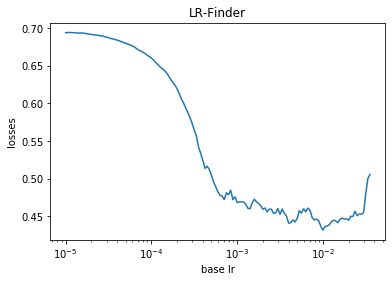

epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.4285 - spearmanr 0.18289
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.39367 - spearmanr 0.33556
best model: epoch 0 - 0.33556
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.37552 - spearmanr 0.34858
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.37268 - spearmanr 0.38478
best model: epoch 1 - 0.38478
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.3582 - spearmanr 0.41121
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.36839 - spearmanr 0.39562
best model: epoch 2 - 0.39562
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.34495 - spearmanr 0.46119
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.36881 - spearmanr 0.4059
best model: epoch 3 - 0.4059
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.33443 - spearmanr 0.49845
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.36927 - spearmanr 0.4051
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 3 - 0.40590
Starting inference for model: checkpoints/bert_base_1_fold_1_best.pth



Starting inference for model: checkpoints/bert_base_1_fold_1_best.pth



Fold 2 started at Mon Dec 30 23:47:43 2019
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.42719 - spearmanr 0.18698
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.38452 - spearmanr 0.34348
best model: epoch 0 - 0.34348
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.37471 - spearmanr 0.35314
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.36679 - spearmanr 0.38808
best model: epoch 1 - 0.38808
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.35881 - spearmanr 0.41226
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.36398 - spearmanr 0.40583
best model: epoch 2 - 0.40583
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.346 - spearmanr 0.45856
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.364 - spearmanr 0.40863
best model: epoch 3 - 0.40863
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.33528 - spearmanr 0.49834
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.36408 - spearmanr 0.40768
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 3 - 0.40863
Starting inference for model: checkpoints/bert_base_1_fold_2_best.pth



Starting inference for model: checkpoints/bert_base_1_fold_2_best.pth



Fold 3 started at Tue Dec 31 00:09:45 2019
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.42761 - spearmanr 0.18247
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.38625 - spearmanr 0.35119
best model: epoch 0 - 0.35119
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.37531 - spearmanr 0.35048
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.36842 - spearmanr 0.38978
best model: epoch 1 - 0.38978
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.35891 - spearmanr 0.41007
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.36481 - spearmanr 0.40777
best model: epoch 2 - 0.40777
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.34556 - spearmanr 0.46132
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.36442 - spearmanr 0.40923
best model: epoch 3 - 0.40923
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.33467 - spearmanr 0.5003
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.36696 - spearmanr 0.40899
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 3 - 0.40923
Starting inference for model: checkpoints/bert_base_1_fold_3_best.pth



Starting inference for model: checkpoints/bert_base_1_fold_3_best.pth



Fold 4 started at Tue Dec 31 00:31:47 2019
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.42657 - spearmanr 0.18298
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.38322 - spearmanr 0.35062
best model: epoch 0 - 0.35062
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.37475 - spearmanr 0.35646
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.3669 - spearmanr 0.39143
best model: epoch 1 - 0.39143
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.35934 - spearmanr 0.4132
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.36485 - spearmanr 0.39624
best model: epoch 2 - 0.39624
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.34575 - spearmanr 0.4628
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.36261 - spearmanr 0.40329
best model: epoch 3 - 0.40329
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.33501 - spearmanr 0.50179
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.36445 - spearmanr 0.40447
best model: epoch 4 - 0.40447
TRAINING END: Best score achieved on epoch 4 - 0.40447
Starting inference for model: checkpoints/bert_base_1_fold_4_best.pth



Starting inference for model: checkpoints/bert_base_1_fold_4_best.pth



Fold 5 started at Tue Dec 31 00:53:49 2019
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.42539 - spearmanr 0.18911
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.38547 - spearmanr 0.33701


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.33701
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.37534 - spearmanr 0.3482
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.37353 - spearmanr 0.38584
best model: epoch 1 - 0.38584
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.35885 - spearmanr 0.41204
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.36539 - spearmanr 0.39577
best model: epoch 2 - 0.39577
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.34587 - spearmanr 0.45951
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.36614 - spearmanr 0.40345
best model: epoch 3 - 0.40345
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.33521 - spearmanr 0.49827
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.36668 - spearmanr 0.40255
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 3 - 0.40345
Starting inference for model: checkpoints/bert_base_1_fold_5_best.pth



Starting inference for model: checkpoints/bert_base_1_fold_5_best.pth



OOF score: 0.40178950332529934


In [13]:
folds = KFold(n_splits=5, random_state=42)
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds.split(train)):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset4(cat_features_train, ids_train, seg_ids_train, train_index, y),
        batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True
    )
    valid_loader = DataLoader(
        TextDataset4(cat_features_train, ids_train, seg_ids_train, valid_index, y),
        batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True
    )
        
    model = CustomBert4(256, cat_features_train.shape[1], bert_type)
    old_weight = deepcopy(model.bert.embeddings.token_type_embeddings.weight.data)
    model.bert.embeddings.token_type_embeddings = nn.Embedding(3, 768)
    model.bert.embeddings.token_type_embeddings.weight.data[:2] = old_weight
    model.bert.embeddings.token_type_embeddings.weight.data[2] *= old_weight.std(dim=1).mean()
    
    if fold_id == 0:
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=2)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / folds.n_splits
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#0.4092#0.4119

In [14]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [15]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.942520,0.723242,0.232647,0.570296,0.658397,0.666712,0.664319,0.641757,0.416601,0.002215,0.633998,0.679664,0.012879,0.201787,0.004748,0.006181,0.070316,0.068010,0.753650,0.000619,0.928802,0.890621,0.561106,0.946742,0.945765,0.802224,0.049283,0.027751,0.866034,0.905870
1,46,0.858946,0.442576,0.005303,0.730208,0.735166,0.906548,0.562396,0.475782,0.033831,0.007957,0.500963,0.165378,0.001859,0.000437,0.000449,0.006820,0.889499,0.224982,0.068215,0.000101,0.588827,0.961968,0.658173,0.977626,0.989321,0.896185,0.954606,0.101876,0.039286,0.893811
2,70,0.901503,0.610997,0.017720,0.695725,0.913734,0.951232,0.595021,0.535822,0.335475,0.001354,0.193559,0.645405,0.020272,0.105948,0.001207,0.004597,0.079068,0.109864,0.788445,0.000625,0.825508,0.920431,0.574406,0.963759,0.960580,0.838748,0.023563,0.069253,0.937084,0.851212
3,132,0.911864,0.426234,0.001493,0.716533,0.781163,0.911204,0.551910,0.452202,0.107273,0.002442,0.567098,0.058759,0.000414,0.000889,0.000058,0.001204,0.847913,0.192336,0.647444,0.000015,0.750623,0.962758,0.680795,0.977154,0.990561,0.909701,0.900567,0.172209,0.474893,0.913161
4,200,0.939431,0.393063,0.036083,0.839027,0.763706,0.877082,0.665243,0.661482,0.175753,0.012460,0.408269,0.396611,0.005327,0.015425,0.005776,0.045415,0.185322,0.139333,0.493281,0.002180,0.673795,0.938535,0.669354,0.976832,0.977043,0.877928,0.165763,0.096645,0.744773,0.939528
